## El conjunto de datos CelebA 

Utilizaremos el conjunto de datos CelebFaces Attributes para entrenar nuestro modelo autocodificador variacional. Se puede encontrar en Kaggle, [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow.keras.backend as K

from scipy.stats import norm

print(f'Versión de TensorFlow: {tf.__version__}')
print(f"Dispositivo de entrenamiento: {tf.config.list_physical_devices('GPU')}")

Versión de TensorFlow: 2.10.0
Dispositivo de entrenamiento: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 64
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [3]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [4]:
import numpy as np
import matplotlib.pyplot as plt


def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector


def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()


def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(
    "../datasets/celebA/img",
    labels=None,
    color_mode='rgb',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation='bilinear'
)

Found 202599 files belonging to 1 classes.


In [6]:
def preprocess(img):
    return tf.cast(img, "float32") / 255.0

train = train_data.map(lambda x: preprocess(x))

In [7]:
train_sample = sample_batch(train)

In [8]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
# Encoder
encoder_input = tf.keras.layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = tf.keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = tf.keras.layers.Flatten()(x)
z_mean = tf.keras.layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = tf.keras.models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 128)  3584        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 128)  0           ['batch_normalization[0][0]

In [10]:
# Decoder
decoder_input = tf.keras.layers.Input(shape=(Z_DIM,), name="decoder_input")
x = tf.keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Reshape(shape_before_flattening)(x)
x = tf.keras.layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU()(x)
decoder_output = tf.keras.layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = tf.keras.models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 2048)              411648    
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                     

In [11]:
class VAE(tf.keras.models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * tf.keras.losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * tf.keras.losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [12]:
vae = VAE(encoder, decoder)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [13]:
# Create a model save checkpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="../checkpoint/capitulo_03",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="../logs/capitulo_03")


class ImageGenerator(tf.keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.utils.array_to_img(generated_images[i])
            img.save("../output/capitulo_03/generated_img_%03d_%d.png" % (epoch, i))

In [14]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("../models/capitulo_03/vae")
    tmp = vae.predict(train.take(1))

In [15]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
1583/1583 [==============================] - ETA: 0s - loss: 95.4244 - reconstruction_loss: 60.4168 - kl_loss: 17.8625

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 193s 120ms/step - loss: 95.4136 - reconstruction_loss: 60.4168 - kl_loss: 17.8625
Epoch 2/10
1583/1583 [==============================] - ETA: 0s - loss: 68.4910 - reconstruction_loss: 50.2207 - kl_loss: 17.6021

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 184s 116ms/step - loss: 68.4906 - reconstruction_loss: 50.2207 - kl_loss: 17.6021
Epoch 3/10
1583/1583 [==============================] - ETA: 0s - loss: 66.4583 - reconstruction_loss: 48.3685 - kl_loss: 17.7879

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 185s 117ms/step - loss: 66.4581 - reconstruction_loss: 48.3685 - kl_loss: 17.7879
Epoch 4/10
1583/1583 [==============================] - ETA: 0s - loss: 65.6143 - reconstruction_loss: 47.6481 - kl_loss: 17.7755

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 181s 114ms/step - loss: 65.6142 - reconstruction_loss: 47.6481 - kl_loss: 17.7755
Epoch 5/10
1583/1583 [==============================] - ETA: 0s - loss: 65.0930 - reconstruction_loss: 47.1794 - kl_loss: 17.8022

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 182s 114ms/step - loss: 65.0929 - reconstruction_loss: 47.1794 - kl_loss: 17.8022
Epoch 6/10
1583/1583 [==============================] - ETA: 0s - loss: 64.7636 - reconstruction_loss: 46.7497 - kl_loss: 17.8777

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 183s 115ms/step - loss: 64.7635 - reconstruction_loss: 46.7497 - kl_loss: 17.8777
Epoch 7/10
1583/1583 [==============================] - ETA: 0s - loss: 64.4505 - reconstruction_loss: 46.3713 - kl_loss: 17.9338

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 184s 116ms/step - loss: 64.4504 - reconstruction_loss: 46.3713 - kl_loss: 17.9338
Epoch 8/10
1583/1583 [==============================] - ETA: 0s - loss: 64.1491 - reconstruction_loss: 46.0239 - kl_loss: 18.0203

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 188s 118ms/step - loss: 64.1490 - reconstruction_loss: 46.0239 - kl_loss: 18.0203
Epoch 9/10
1583/1583 [==============================] - ETA: 0s - loss: 63.9626 - reconstruction_loss: 45.7571 - kl_loss: 18.1065

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 216s 136ms/step - loss: 63.9625 - reconstruction_loss: 45.7571 - kl_loss: 18.1065
Epoch 10/10
1583/1583 [==============================] - ETA: 0s - loss: 63.7365 - reconstruction_loss: 45.4907 - kl_loss: 18.1516

INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


INFO:tensorflow:Assets written to: ../checkpoint\capitulo_03\assets


1583/1583 [==============================] - 216s 136ms/step - loss: 63.7365 - reconstruction_loss: 45.4907 - kl_loss: 18.1516


In [16]:
# Save the final models
vae.save("../models/capitulo_03/vae")
encoder.save("../models/capitulo_03/encoder")
decoder.save("../models/capitulo_03/decoder")

INFO:tensorflow:Assets written to: ../models/capitulo_03/vae\assets


INFO:tensorflow:Assets written to: ../models/capitulo_03/vae\assets


INFO:tensorflow:Assets written to: ../models/capitulo_03/encoder\assets


INFO:tensorflow:Assets written to: ../models/capitulo_03/encoder\assets


INFO:tensorflow:Assets written to: ../models/capitulo_03/decoder\assets


INFO:tensorflow:Assets written to: ../models/capitulo_03/decoder\assets


In [17]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 0s 16ms/step
Example real faces


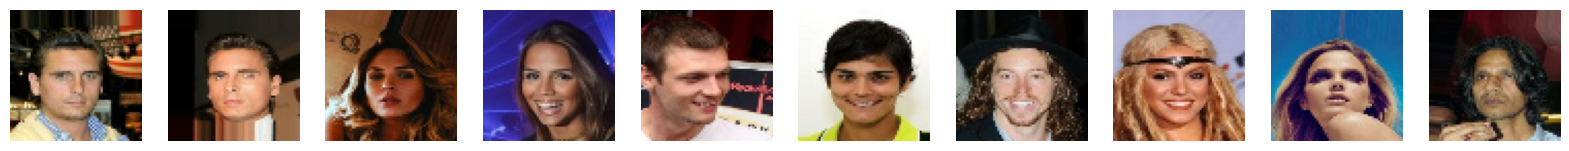

Reconstructions


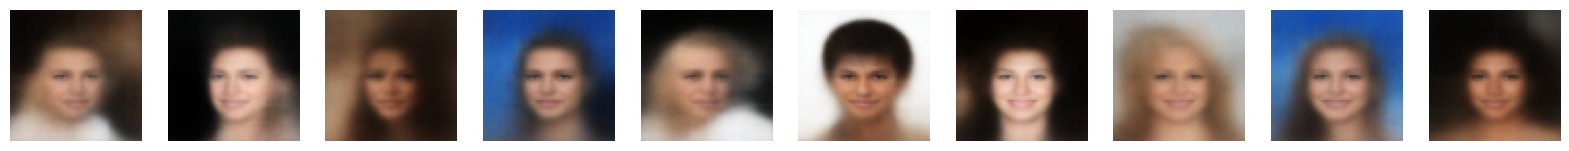

In [18]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

4/4 [==============================] - 0s 5ms/step


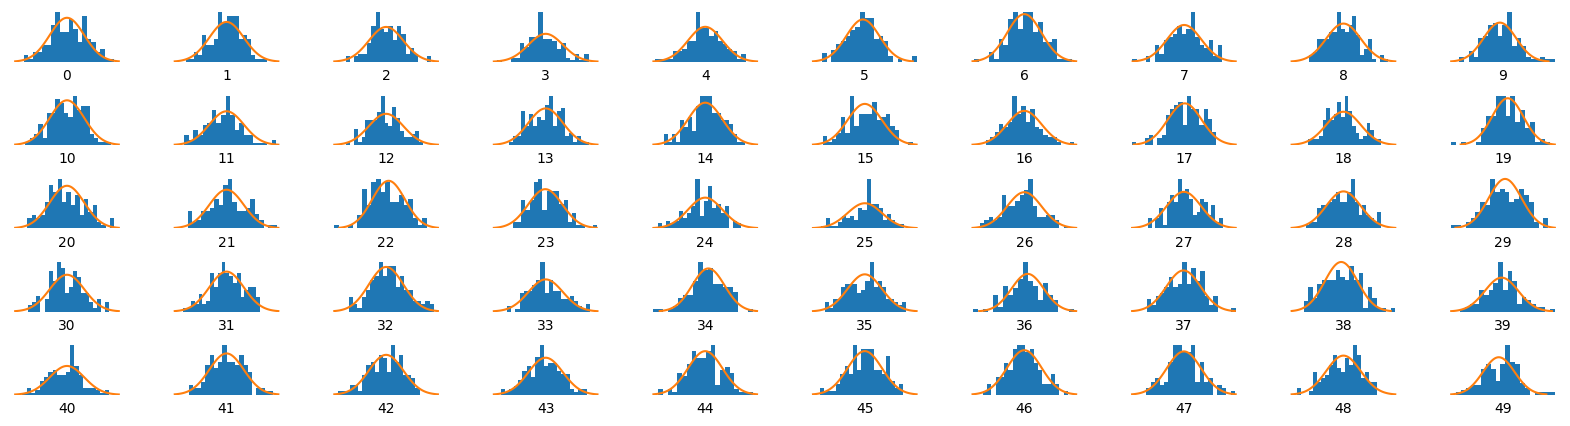

In [19]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

In [20]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [21]:

# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 233ms/step


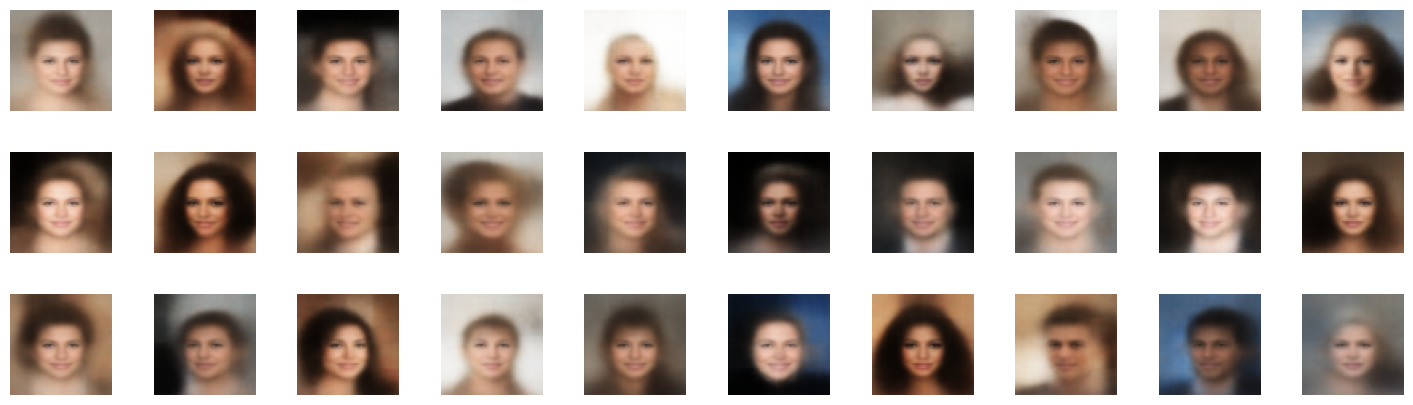

In [22]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

In [23]:
# Load the label dataset
attributes = pd.read_csv("../datasets/celebA/list_attr_celeba.csv")
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [24]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = tf.keras.utils.image_dataset_from_directory(
    "../datasets/celebA/img",
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

ValueError: Expected the lengths of `labels` to match the number of files in the target directory. len(labels) is 202599 while we found 0 files in directory ../datasets/celebA/img.

In [ ]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

In [ ]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

In [ ]:
morph_faces(labelled, vae)